## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_horizontal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

print(CWD)
print(os.getcwd())
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/horizontal/gray
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/horizontal/gray


'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/horizontal/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2446,
 3: 9784,
 4: 39136,
 5: 156544,
 6: 626176,
 7: 2504704,
 8: 10018816,
 9: 40075264}

Running 12760 CDFs


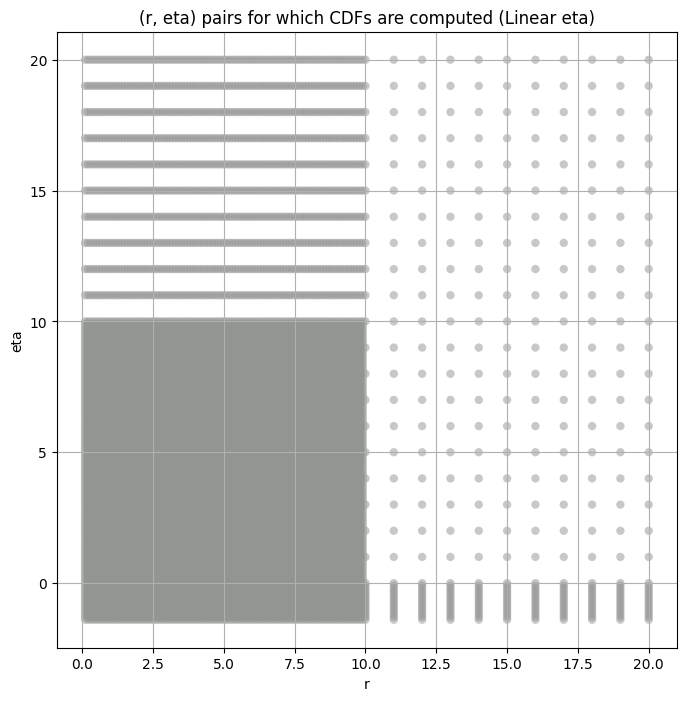

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7033.109400  6575.202000  7502.255000  -0.389985   -0.521723   
3      1485.386800  1423.772500  1548.948900   0.637286    0.503919   
4       299.227260   283.794860   315.127100   2.125775    1.787534   
5        58.351280    54.677464    62.158474   4.274248    3.563068   
6        11.546280    10.649501    12.528811   7.894427    5.764907   
7         2.319492     2.104414     2.579518  13.343580    8.176902   
8         0.523807     0.467204     0.608356  23.059578   10.370432   
9         0.142163     0.126417     0.166078  25.015984   11.196094   

       kurt_upper  total_samples  
layer                             
2       -0.248600           2446  
3        0.776592           9784  
4        2.500192          39136  
5        5.217214         156544  
6       14.354151         626176  
7       37.261646        2504704  
8       96.503456       10018816  
9       99.903610       40075264

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      7033.109400    7033.109375     6331.848145     5802.628906   
3      1485.386800    1485.386841     1413.610229     1357.977905   
4       299.227260     299.227264      291.212280      285.414886   
5        58.351280      58.351280       57.284412       56.489254   
6        11.546280      11.546280       11.189078       10.976361   
7         2.319492       2.319492        2.223263        2.169882   
8         0.523807       0.523807        0.496104        0.482338   
9         0.142163       0.142163        0.134189        0.130235   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         5349.167969      4955.759766      4288.237793      3746.049805   
3         1307.171387      1261.061768      1179.857178      1109.891113   
4          280.420410       275.821198       267.538177       260.083344   
5           55.797066        55.170761        54.042141        53.027149   
6           10.796039        10.635880        10.353992        10.103989   
7            2.125182         2.085600         2.016597         1.956683   
8            0.470753         0.460499         0.442679         0.427248   
9            0.126948         0.124055         0.119036         0.114706   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          3274.055420      2848.021729      2467.784668      1561.933594  
3          1046.696655       990.106506       939.054626       808.604309  
4           253.244537       246.926971       241.146896       225.764816  
5            52.093483        51.227928        50.418858        48.228008  
6             9.877007         9.668549         9.474363         8.958568  
7             1.902932         1.853930         1.808713         1.689855  
8             0.413506         0.401055         0.389654         0.360147  
9             0.110863         0.107390         0.104216         0.096025

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.06060610918372633 7033.1094


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.073055765154044 6331.848


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.08350898888925262 5802.629


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.09331338673024403 5349.168


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.10254342660676563 4955.76


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.11999528679623483 4288.238


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.13612117188915007 3746.0498


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.1518333592290374 3274.0554


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.1675244671937235 2848.0217


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.18345402158513147 2467.7847


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.23281088420348228 1561.9336
Number of samples: 2446, Without approximation : 2446


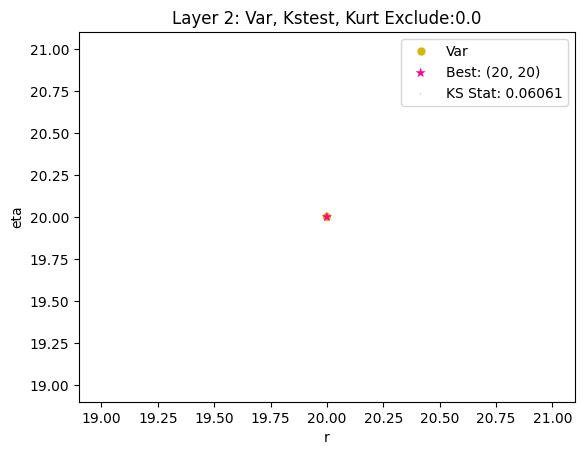

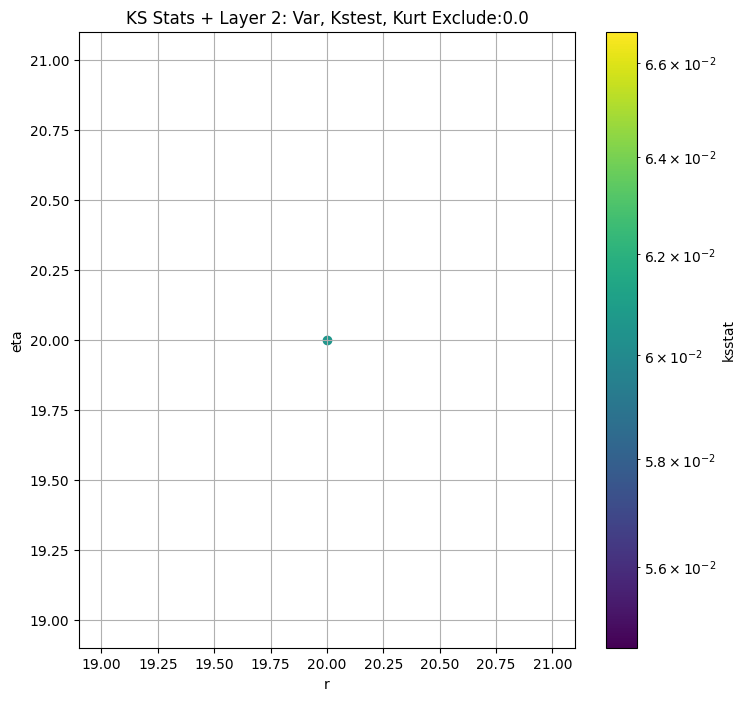

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.046236559690954804 1485.3868


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.04625859149901329 1413.6102


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.046260052420113384 1357.9779


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.04626963611069368 1307.1714


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.046266183552438056 1261.0618


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.04634364616958864 1179.8572


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.046454388252214096 1109.8911


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.04870472575789919 1046.6967


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.05219045457262328 990.1065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.058167881383141995 939.0546


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.07503239824822339 808.6043
Number of samples: 9784, Without approximation : 9784


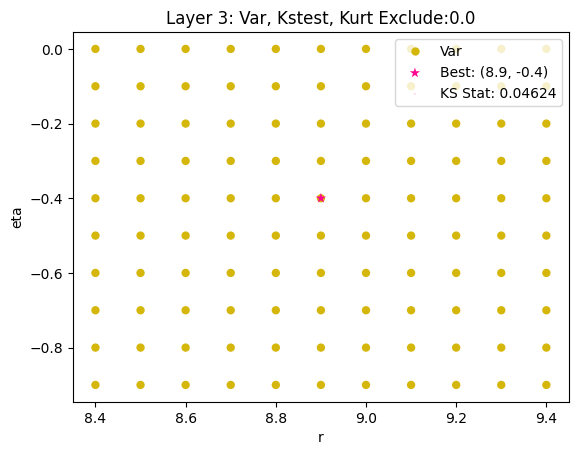

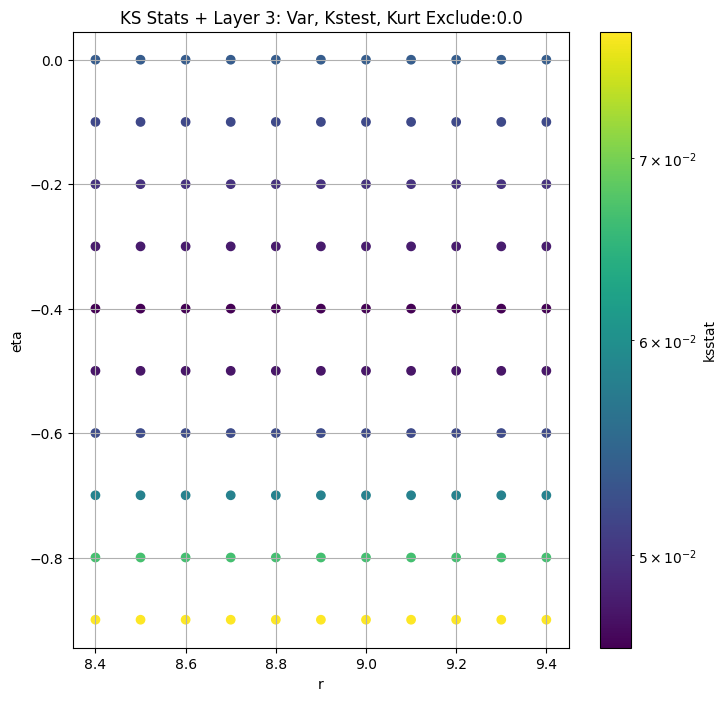

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.029502577979112654 299.22726


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.029501345979500604 291.21228


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.029501803614638056 285.4149


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.029502158578839144 280.4204


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.029508048380491148 275.8212


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.029500476202675985 267.53818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.029501557155673652 260.08334


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.029499753688179087 253.24454


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.02950025714942356 246.92697


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.02950115093642708 241.1469


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.03007790825728135 225.76482
Number of samples: 39136, Without approximation : 39136


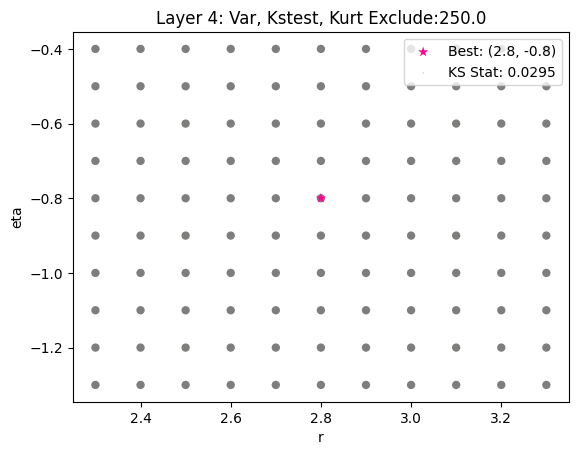

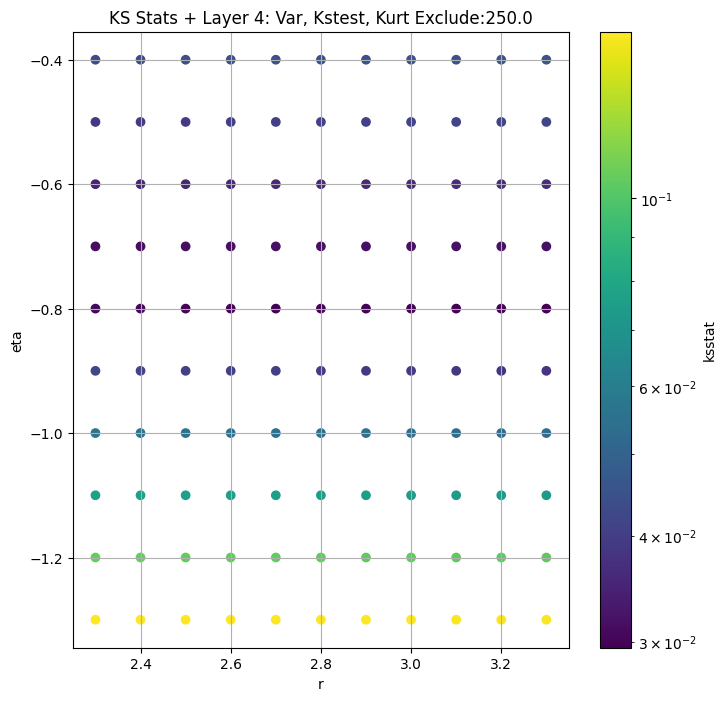

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.024818333513080326 58.35128


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.024804302312855242 57.284412


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.024793593696628258 56.489254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.024784090745753384 55.797066


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.0247753424567847 55.17076


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.02476092794363488 54.04214


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.02474775118459327 53.02715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.02473530218375891 52.093483


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.024831748852365942 51.22793


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.02482074771219417 50.418858


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.024789603185362385 48.22801
Number of samples: 100000, Without approximation : 156544


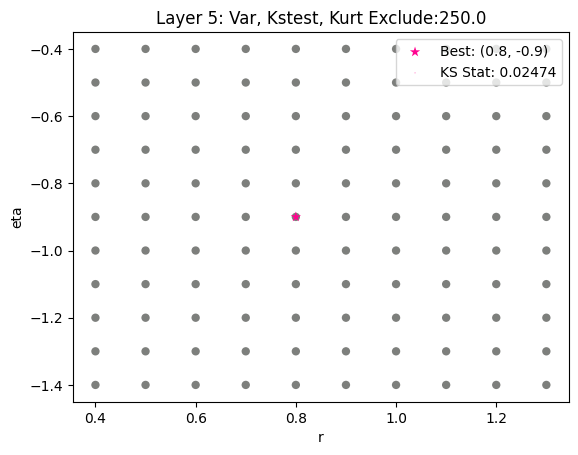

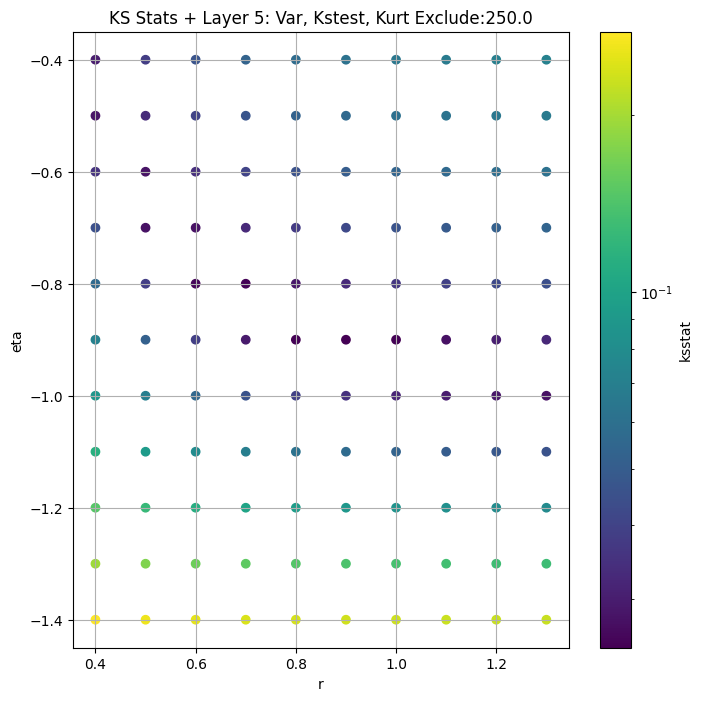

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.025794809980954014 11.54628


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.02561719279255692 11.189078


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.02562877801966662 10.976361


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.025404035040338058 10.796039


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.0255271678675425 10.63588


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.02537926679045177 10.3539915


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.025228561956758933 10.103989


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.025195848867404447 9.8770075


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.02524022619178995 9.668549


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.0251753055340716 9.474363


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.025075710981771526 8.958568
Number of samples: 100000, Without approximation : 626176


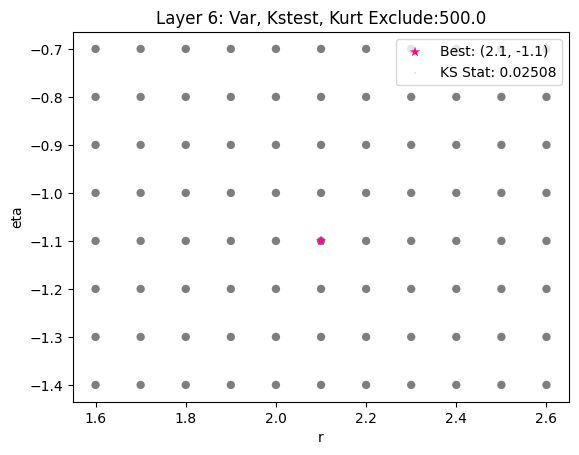

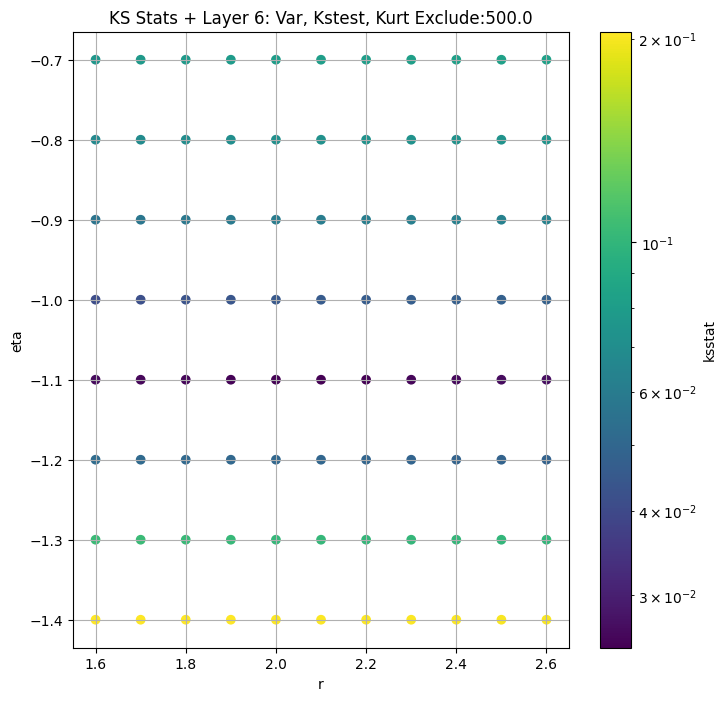

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.026778571098576842 2.319492


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.026765253315543996 2.2232628


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.026545525317918095 2.1698818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.02656173436195297 2.1251822


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.026460849717615087 2.0856004


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.02636927678175749 2.0165966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.026248312590680167 1.9566832


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.02625636869426351 1.9029316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.02692358301347364 1.8539295


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.027560144989220436 1.8087133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.02800744101731295 1.6898555
Number of samples: 100000, Without approximation : 2504704


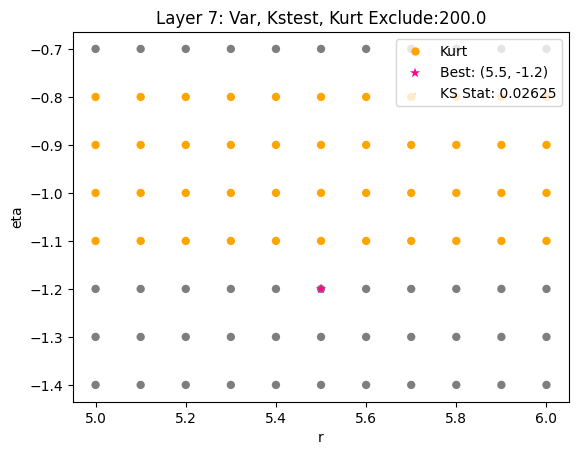

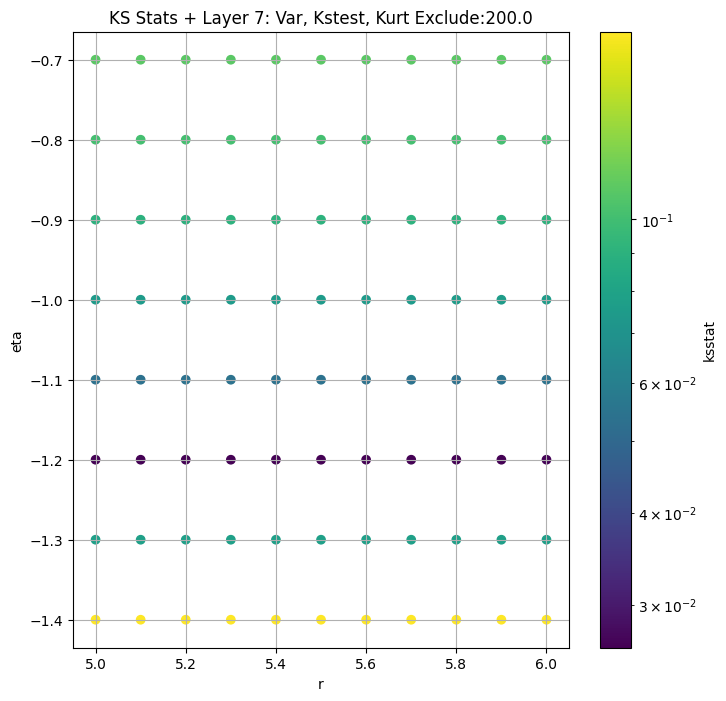

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.012953819700703306 0.5238069


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.014818287491322302 0.4961037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.01468327102767436 0.4823379


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.01443649393114449 0.47075307


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.014211788817907023 0.46049872


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.013701247818979745 0.44267857


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.011804670008780604 0.42724812


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.010492025032550811 0.41350597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.011449207070508893 0.4010552


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.01245666144436719 0.3896543


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.01274600733204112 0.36014673
Number of samples: 100000, Without approximation : 10018816


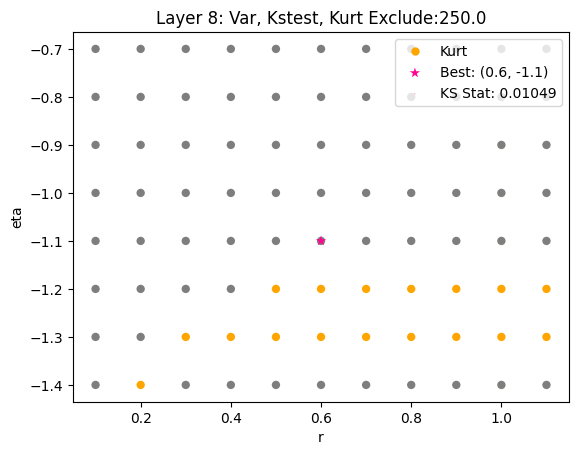

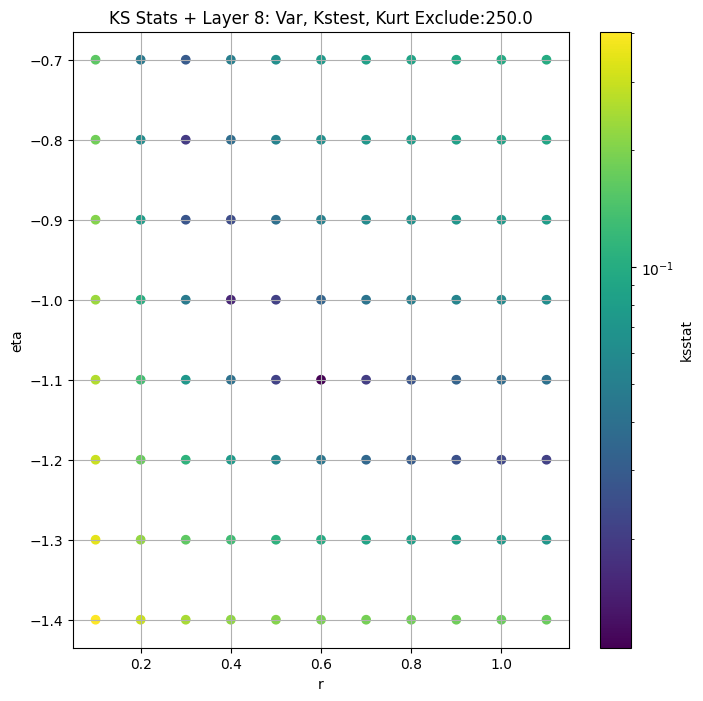

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.013645067889784146 0.14216252


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.014316237930063813 0.13418868


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.013121486648089653 0.13023525


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.012113903949111993 0.12694791


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.011212585860775781 0.12405505


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.009631552217946093 0.11903561


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.009019917470292627 0.11470598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.009182337585836753 0.11086289


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.010033815271333846 0.10739042


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.011545667161175666 0.10421586


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.012962917629493309 0.09602547
Number of samples: 100000, Without approximation : 40075264


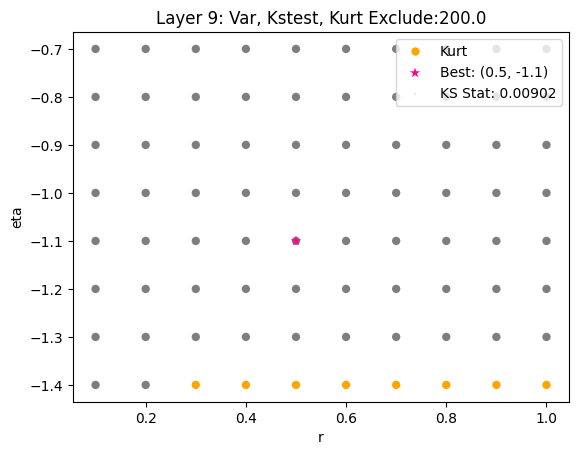

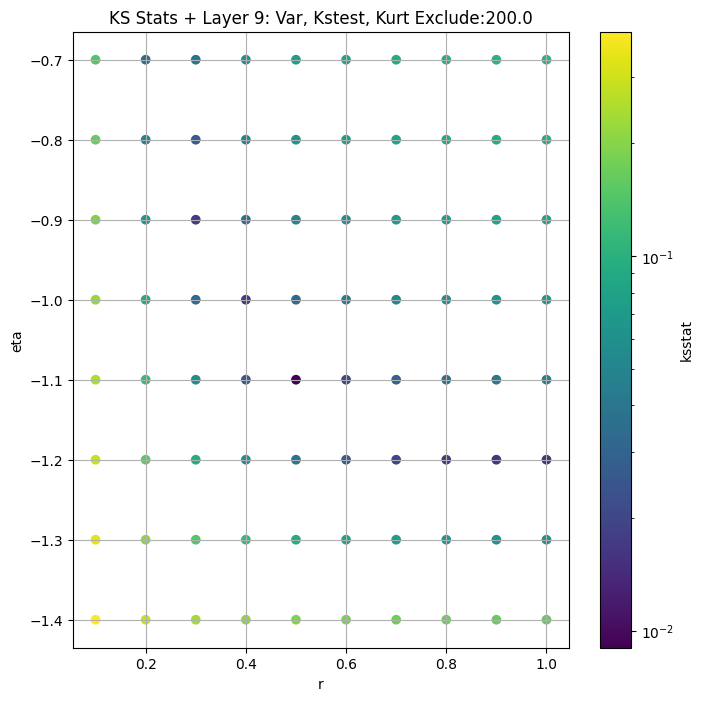

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7033.109400  6575.202000  7502.255000  -0.389985   -0.521723   
3      1485.386800  1423.772500  1548.948900   0.637286    0.503919   
4       299.227260   283.794860   315.127100   2.125775    1.787534   
5        58.351280    54.677464    62.158474   4.274248    3.563068   
6        11.546280    10.649501    12.528811   7.894427    5.764907   
7         2.319492     2.104414     2.579518  13.343580    8.176902   
8         0.523807     0.467204     0.608356  23.059578   10.370432   
9         0.142163     0.126417     0.166078  25.015984   11.196094   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.248600           2446             0.060606       20.0         20.0   
3        0.776592           9784             0.046237        8.9         -0.4   
4        2.500192          39136             0.029500        2.8         -0.8   
5        5.217214         156544             0.024735        0.8         -0.9   
6       14.354151         626176             0.025076        2.1         -1.1   
7       37.261646        2504704             0.026248        5.5         -1.2   
8       96.503456       10018816             0.010492        0.6         -1.1   
9       99.903610       40075264             0.009020        0.5         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        7183.784645                     0.0         7033.109400   
3        2938.163651                     0.0         1485.386800   
4         623.317801                   250.0          253.244540   
5          63.836224                   250.0           52.093483   
6          31.980442                   500.0            8.958568   
7           9.057073                   200.0            1.956683   
8           0.470282                   250.0            0.413506   
9           0.079657                   200.0            0.114706   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.027391  
3                     0.013713  
4                     0.006861  
5                     0.003431  
6                     0.001716  
7                     0.000858  
8                     0.000429  
9                     0.000215

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.10254342660676563, var: 4955.759765625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.09331338673024403, var: 5349.16796875


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.08350898888925262, var: 5802.62890625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.073055765154044, var: 6331.84814453125


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.06060610918372633, var: 7033.109375
Number of samples: 2446, Without approximation : 2446


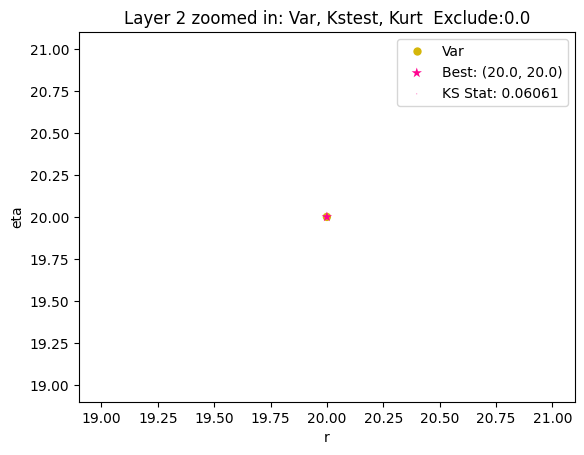

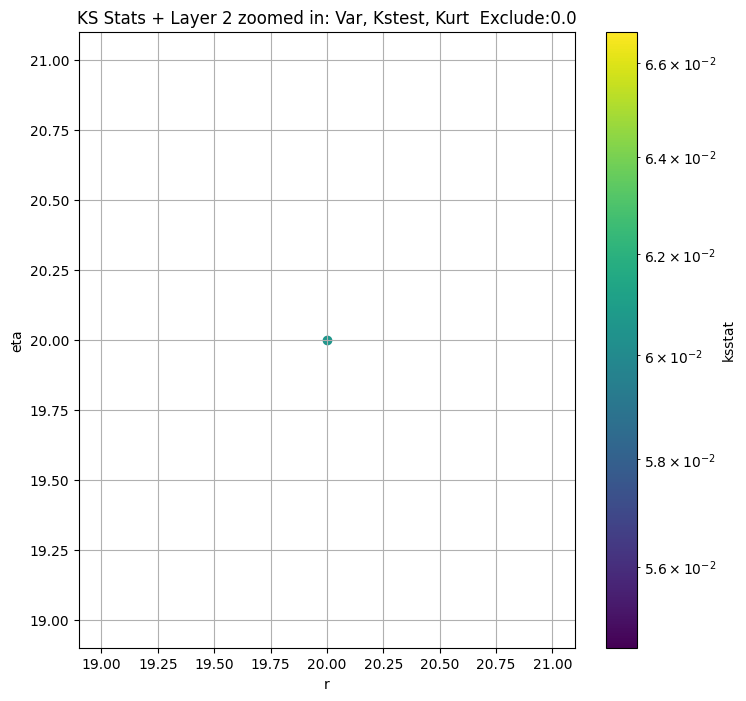

Layer 3


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.04628110564868959, var: 1261.061767578125


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.04627017423643737, var: 1307.17138671875


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.04628027721240091, var: 1357.9779052734375


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.046279777046016435, var: 1413.6102294921875


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.046236559690954804, var: 1485.3868408203125
Number of samples: 9784, Without approximation : 9784


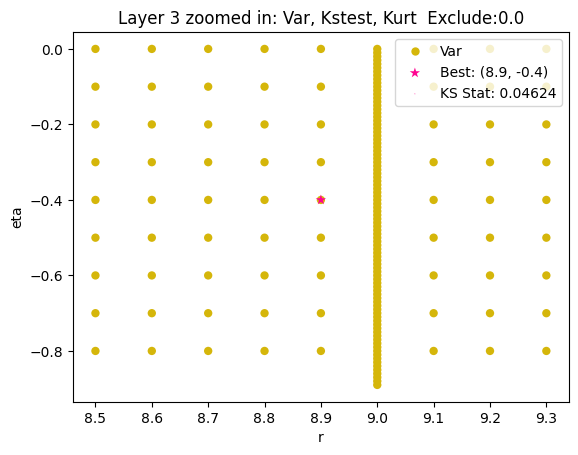

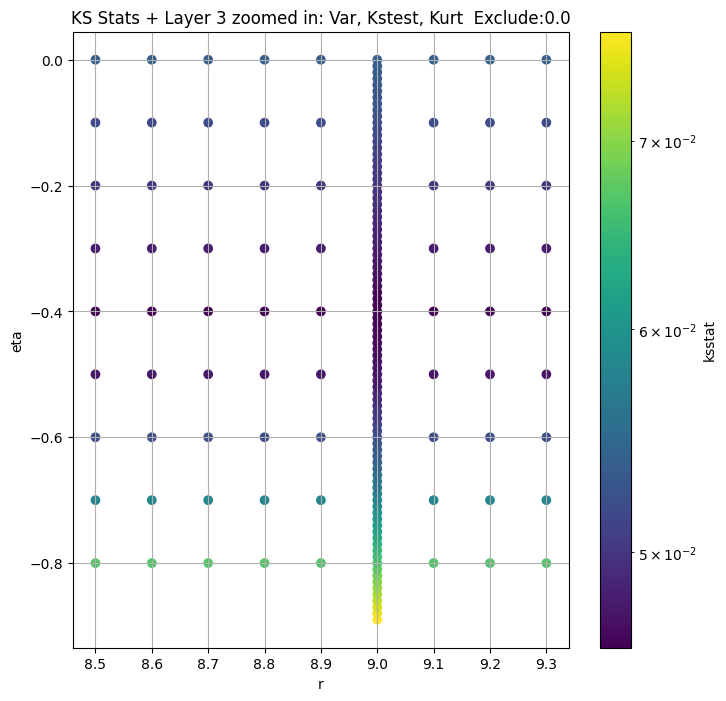

Layer 4


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 4, 250.0 + 100 = 350, ksstat: 0.02953119440666402, var: 241.1468963623047


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 4, 250.0 + 75 = 325, ksstat: 0.029515943170543346, var: 243.98516845703125


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 4, 250.0 + 50 = 300, ksstat: 0.029506398059105376, var: 246.92697143554688


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 4, 250.0 + 25 = 275, ksstat: 0.029501684262994377, var: 250.0185546875


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 4, 250.0 + 0 = 250, ksstat: 0.029499753688179087, var: 253.24453735351562


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 4, 250.0 + -25 = 225, ksstat: 0.029499229034103402, var: 256.5969543457031


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 4, 250.0 + -50 = 200, ksstat: 0.029500128475720255, var: 260.0833435058594


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 4, 250.0 + -75 = 175, ksstat: 0.029503664616860714, var: 263.7227478027344


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 4, 250.0 + -100 = 150, ksstat: 0.029510024870507023, var: 267.5381774902344
Number of samples: 39136, Without approximation : 39136


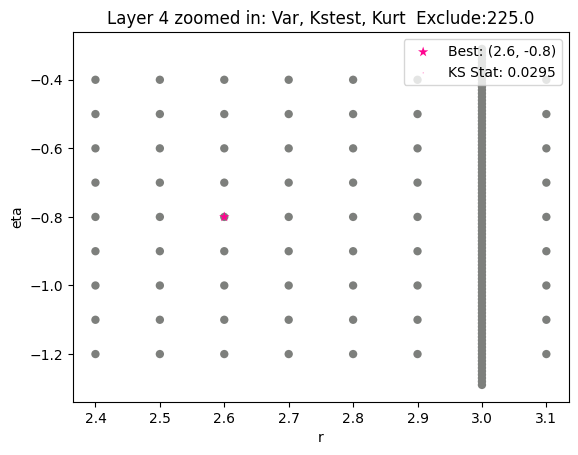

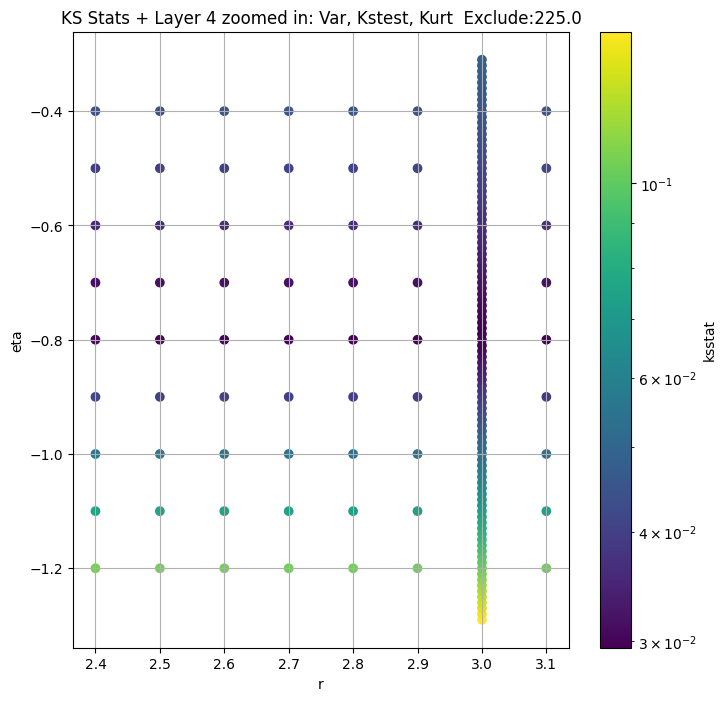

Layer 5


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 250.0 + 100 = 350, ksstat: 0.024670609577779223, var: 50.41885757446289


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 250.0 + 75 = 325, ksstat: 0.024676622086352018, var: 50.81735610961914


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 250.0 + 50 = 300, ksstat: 0.024625350426608794, var: 51.227928161621094


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 250.0 + 25 = 275, ksstat: 0.024616312597122936, var: 51.651824951171875


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 250.0 + 0 = 250, ksstat: 0.024622552313038115, var: 52.093482971191406


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 250.0 + -25 = 225, ksstat: 0.024628944589388024, var: 52.55173873901367


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 250.0 + -50 = 200, ksstat: 0.02463548985042263, var: 53.02714920043945


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 250.0 + -75 = 175, ksstat: 0.02464221622271051, var: 53.52235412597656


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 250.0 + -100 = 150, ksstat: 0.024649178428857055, var: 54.04214096069336
Number of samples: 100000, Without approximation : 156544


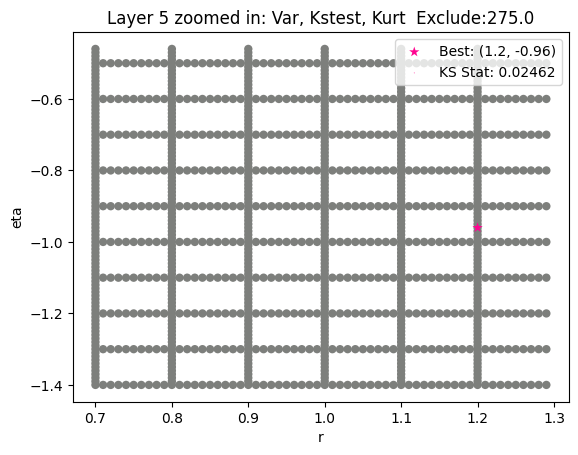

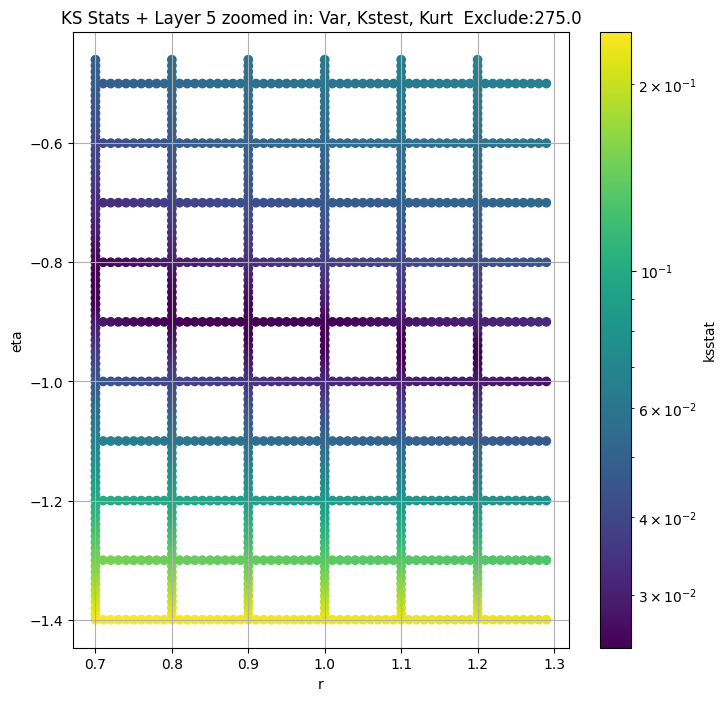

Layer 6


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 6, 500.0 + 100 = 600, ksstat: 0.024229921769694962, var: 8.656344413757324


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 6, 500.0 + 75 = 575, ksstat: 0.024338080146349306, var: 8.729278564453125


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 6, 500.0 + 50 = 550, ksstat: 0.024346940393872418, var: 8.803864479064941


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 6, 500.0 + 25 = 525, ksstat: 0.024370172225697484, var: 8.880208969116211


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 6, 500.0 + 0 = 500, ksstat: 0.02439586208444966, var: 8.95856761932373


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 6, 500.0 + -25 = 475, ksstat: 0.024432093806125432, var: 9.038872718811035


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 6, 500.0 + -50 = 450, ksstat: 0.024337622209654408, var: 9.121164321899414


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 6, 500.0 + -75 = 425, ksstat: 0.024864614440829103, var: 9.2057466506958


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 6, 500.0 + -100 = 400, ksstat: 0.025025877142107134, var: 9.292603492736816
Number of samples: 100000, Without approximation : 626176


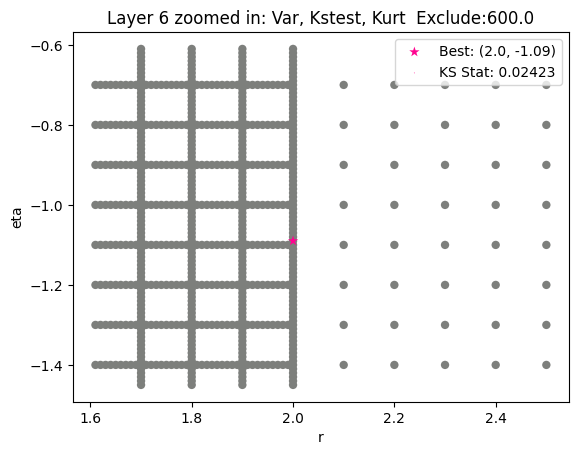

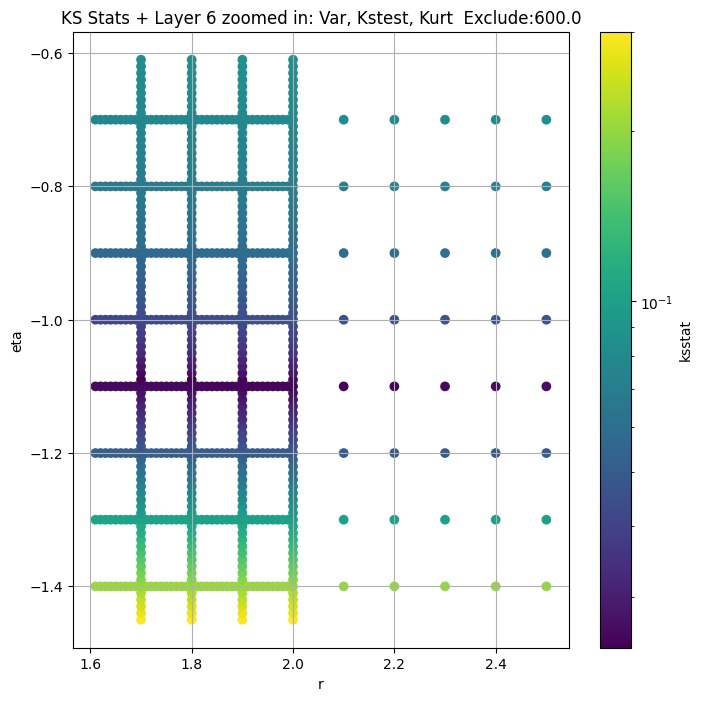

Layer 7


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 7, 200.0 + 100 = 300, ksstat: 0.027529083948886868, var: 1.8539295196533203


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 7, 200.0 + 75 = 275, ksstat: 0.027197669132287827, var: 1.8778921365737915


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 7, 200.0 + 50 = 250, ksstat: 0.02685694868465105, var: 1.902931571006775


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 7, 200.0 + 25 = 225, ksstat: 0.026506086752551505, var: 1.9291530847549438


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 7, 200.0 + 0 = 200, ksstat: 0.026248312590680167, var: 1.9566831588745117


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 7, 200.0 + -25 = 175, ksstat: 0.026889701284350503, var: 1.9857386350631714


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 7, 200.0 + -50 = 150, ksstat: 0.027802657625890126, var: 2.016596555709839


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 7, 200.0 + -75 = 125, ksstat: 0.02876505886573577, var: 2.0497071743011475


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 7, 200.0 + -100 = 100, ksstat: 0.02978888871089863, var: 2.0856003761291504
Number of samples: 100000, Without approximation : 2504704


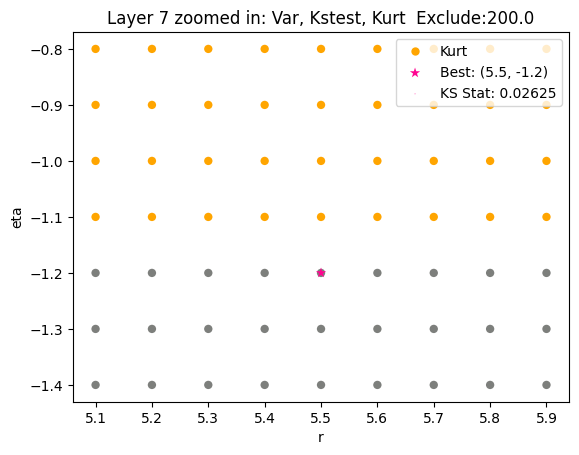

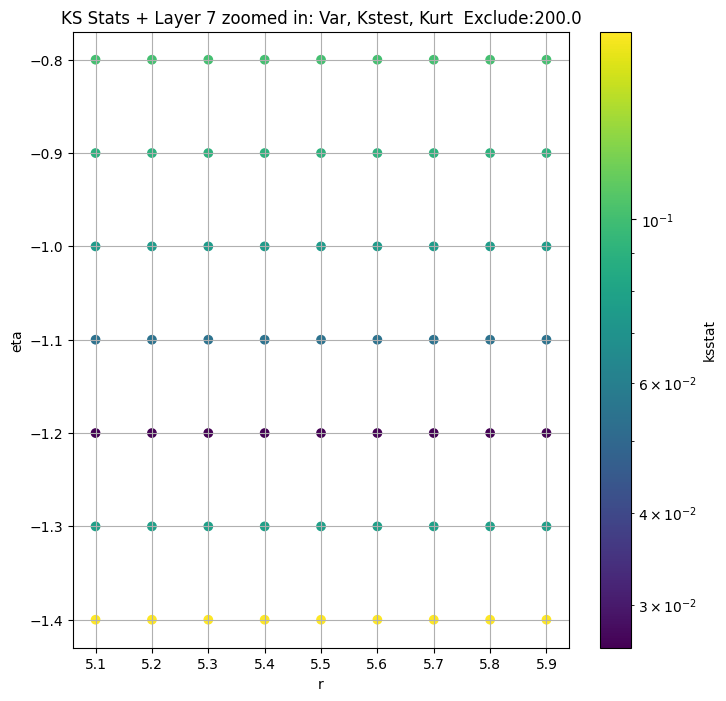

Layer 8


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 250.0 + 100 = 350, ksstat: 0.010742246737819983, var: 0.3896543085575104


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 250.0 + 75 = 325, ksstat: 0.010613463755715036, var: 0.3952358663082123


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 250.0 + 50 = 300, ksstat: 0.010591584118763486, var: 0.4010551869869232


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 250.0 + 25 = 275, ksstat: 0.010630361622153028, var: 0.4071349501609802


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 250.0 + 0 = 250, ksstat: 0.010492025032550811, var: 0.4135059714317322


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 250.0 + -25 = 225, ksstat: 0.01075575865360523, var: 0.4201960861682892


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 250.0 + -50 = 200, ksstat: 0.010626628339001465, var: 0.42724812030792236


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 250.0 + -75 = 175, ksstat: 0.010534004938325459, var: 0.434718519449234


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 250.0 + -100 = 150, ksstat: 0.010866402789364349, var: 0.4426785707473755
Number of samples: 100000, Without approximation : 10018816


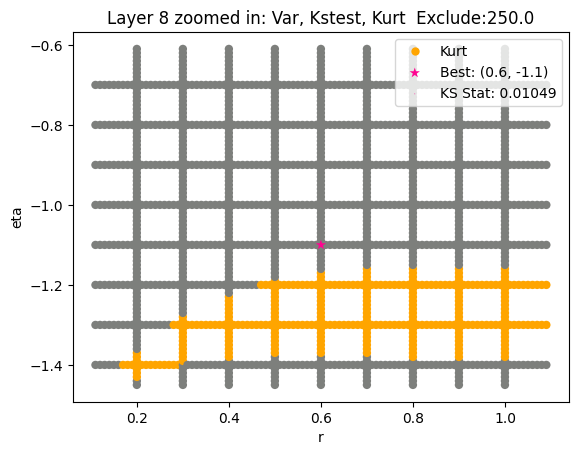

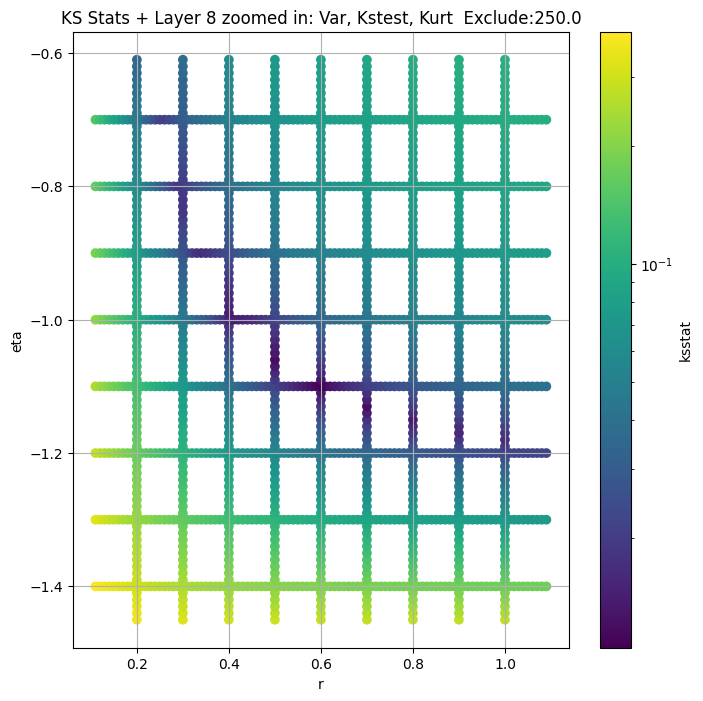

Layer 9


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 200.0 + 100 = 300, ksstat: 0.009045648523204886, var: 0.10739041864871979


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 200.0 + 75 = 275, ksstat: 0.009069185512339484, var: 0.10908544063568115


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 200.0 + 50 = 250, ksstat: 0.008996080574254606, var: 0.11086288839578629


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 200.0 + 25 = 225, ksstat: 0.009097622652192383, var: 0.11273213475942612


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 200.0 + 0 = 200, ksstat: 0.009019917470292627, var: 0.11470597982406616


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 200.0 + -25 = 175, ksstat: 0.009114214051104186, var: 0.1168002262711525


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 200.0 + -50 = 150, ksstat: 0.00909196640494836, var: 0.11903560906648636


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 200.0 + -75 = 125, ksstat: 0.009046521936415197, var: 0.12144019454717636


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 200.0 + -100 = 100, ksstat: 0.009128668973824694, var: 0.12405505031347275
Number of samples: 100000, Without approximation : 40075264


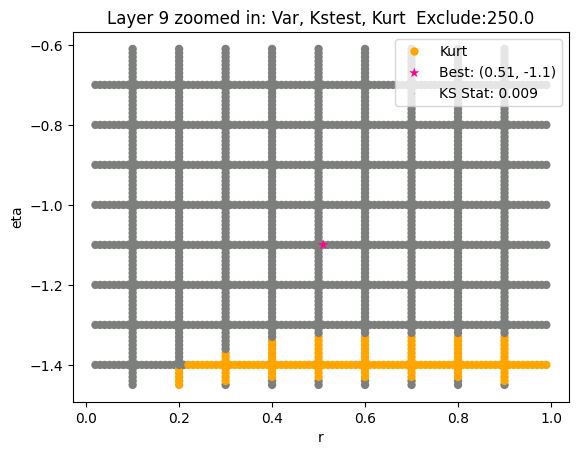

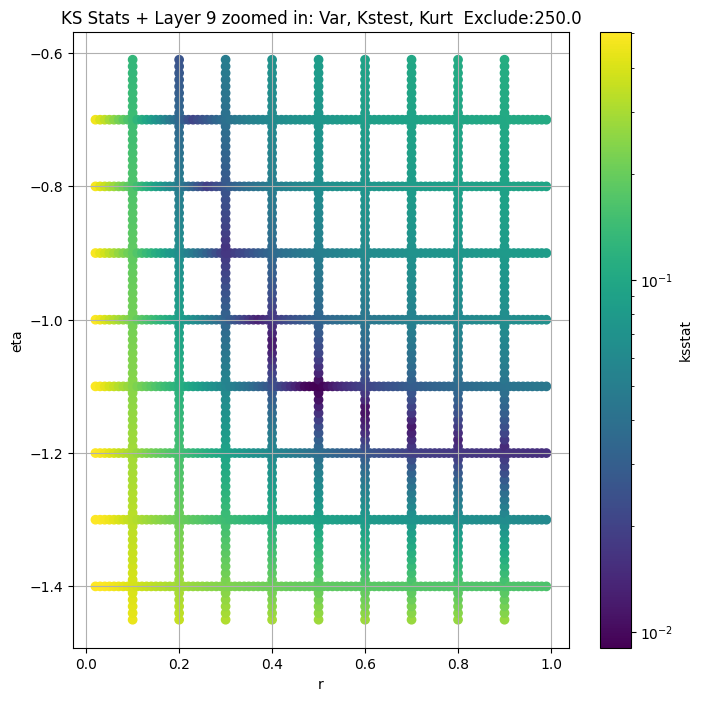

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7033.109400  6575.202000  7502.255000  -0.389985   -0.521723   
3      1485.386800  1423.772500  1548.948900   0.637286    0.503919   
4       299.227260   283.794860   315.127100   2.125775    1.787534   
5        58.351280    54.677464    62.158474   4.274248    3.563068   
6        11.546280    10.649501    12.528811   7.894427    5.764907   
7         2.319492     2.104414     2.579518  13.343580    8.176902   
8         0.523807     0.467204     0.608356  23.059578   10.370432   
9         0.142163     0.126417     0.166078  25.015984   11.196094   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.248600           2446             0.060606       20.0         20.0   
3        0.776592           9784             0.046237        8.9         -0.4   
4        2.500192          39136             0.029500        2.8         -0.8   
5        5.217214         156544             0.024735        0.8         -0.9   
6       14.354151         626176             0.025076        2.1         -1.1   
7       37.261646        2504704             0.026248        5.5         -1.2   
8       96.503456       10018816             0.010492        0.6         -1.1   
9       99.903610       40075264             0.009020        0.5         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        7183.784645                     0.0         7033.109400   
3        2938.163651                     0.0         1485.386800   
4         623.317801                   250.0          256.596954   
5          63.836224                   250.0           51.651825   
6          31.980442                   500.0            8.656344   
7           9.057073                   200.0            1.956683   
8           0.470282                   250.0            0.413506   
9           0.079657                   200.0            0.110863   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.027391          0.060606   20.00     20.00   
3                     0.013713          0.046237    8.90     -0.40   
4                     0.006861          0.029499    2.60     -0.80   
5                     0.003431          0.024616    1.20     -0.96   
6                     0.001716          0.024230    2.00     -1.09   
7                     0.000858          0.026248    5.50     -1.20   
8                     0.000429          0.010492    0.60     -1.10   
9                     0.000215          0.008996    0.51     -1.10   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      7183.784645                  0.0          513  
3      2938.163651                  0.0          868  
4       624.506493                225.0         2062  
5       112.934627                275.0         3094  
6        30.007037                600.0         3094  
7         9.057073                200.0         2751  
8         0.470282                250.0        16510  
9         0.081824                250.0        22014

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

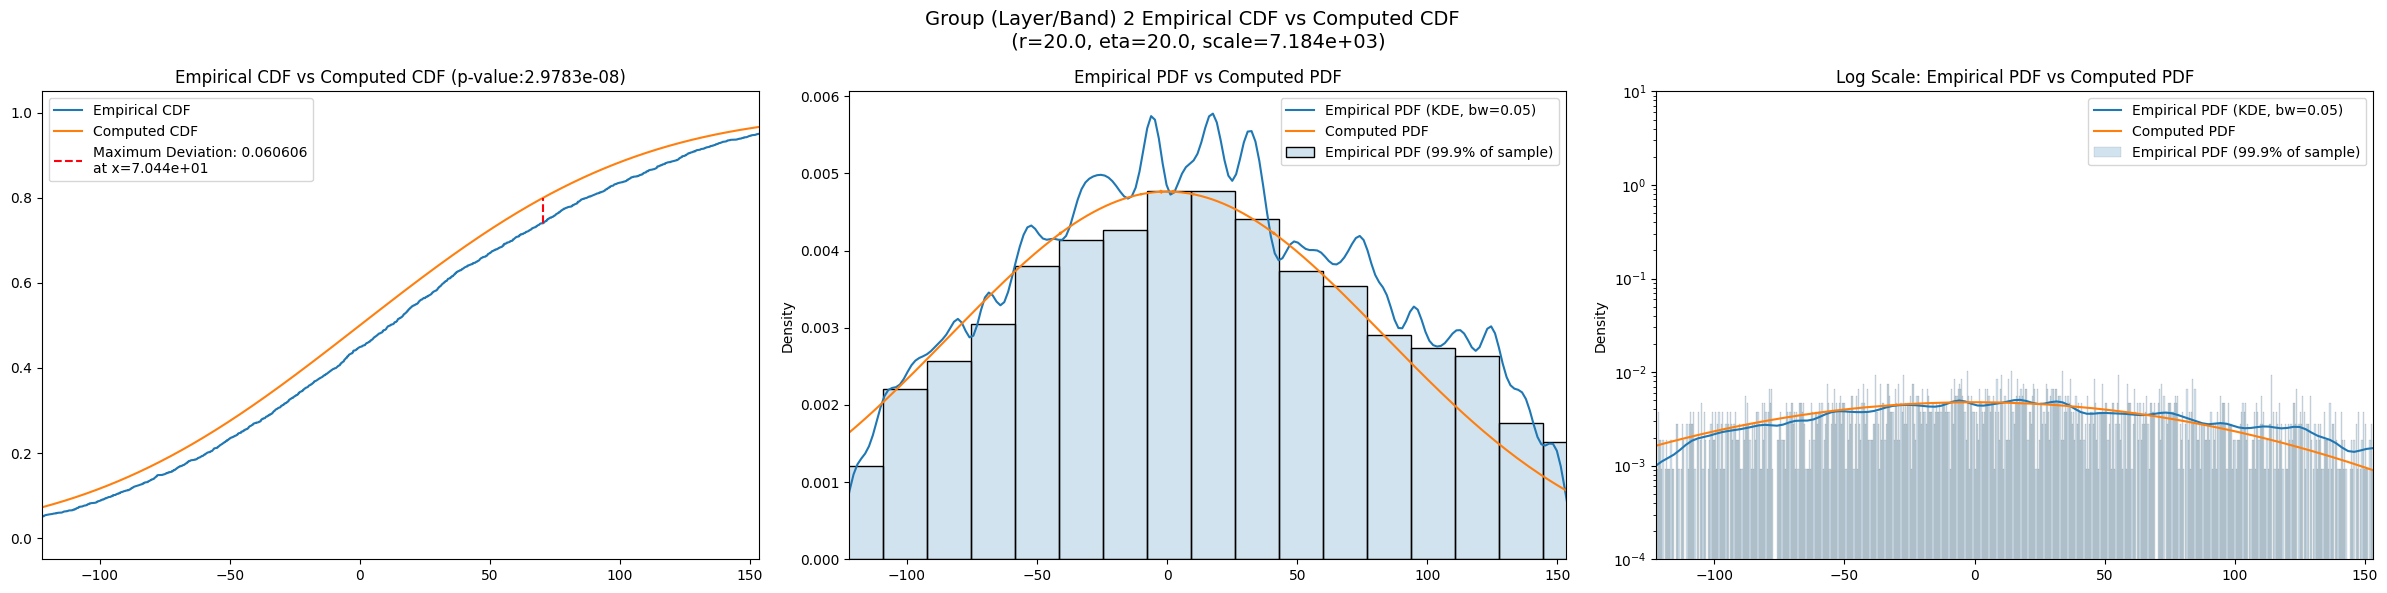

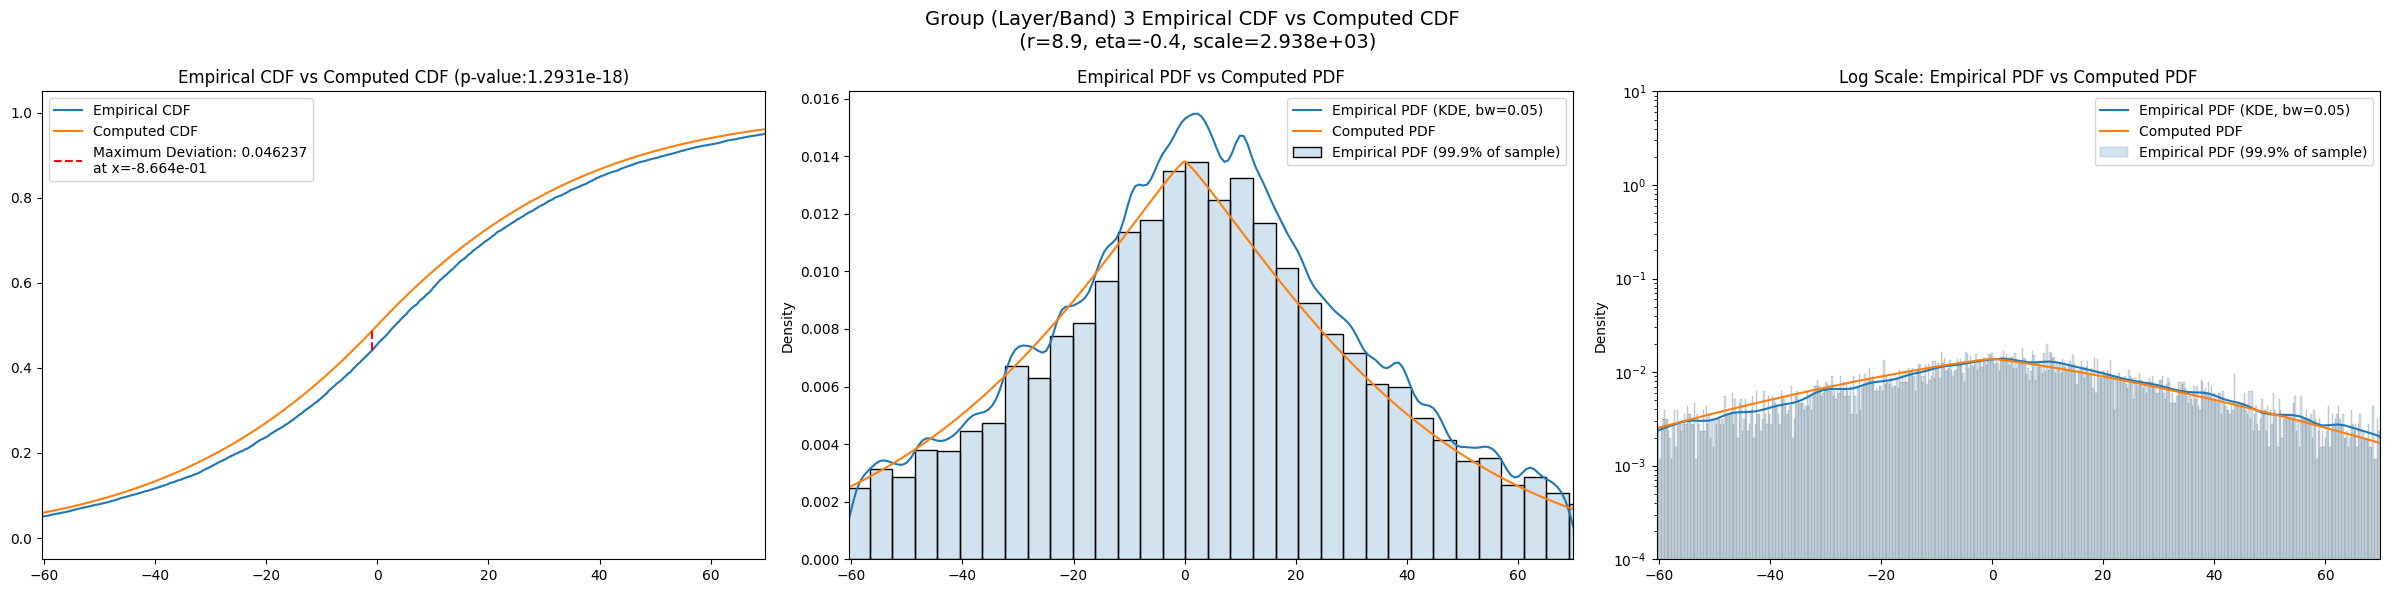

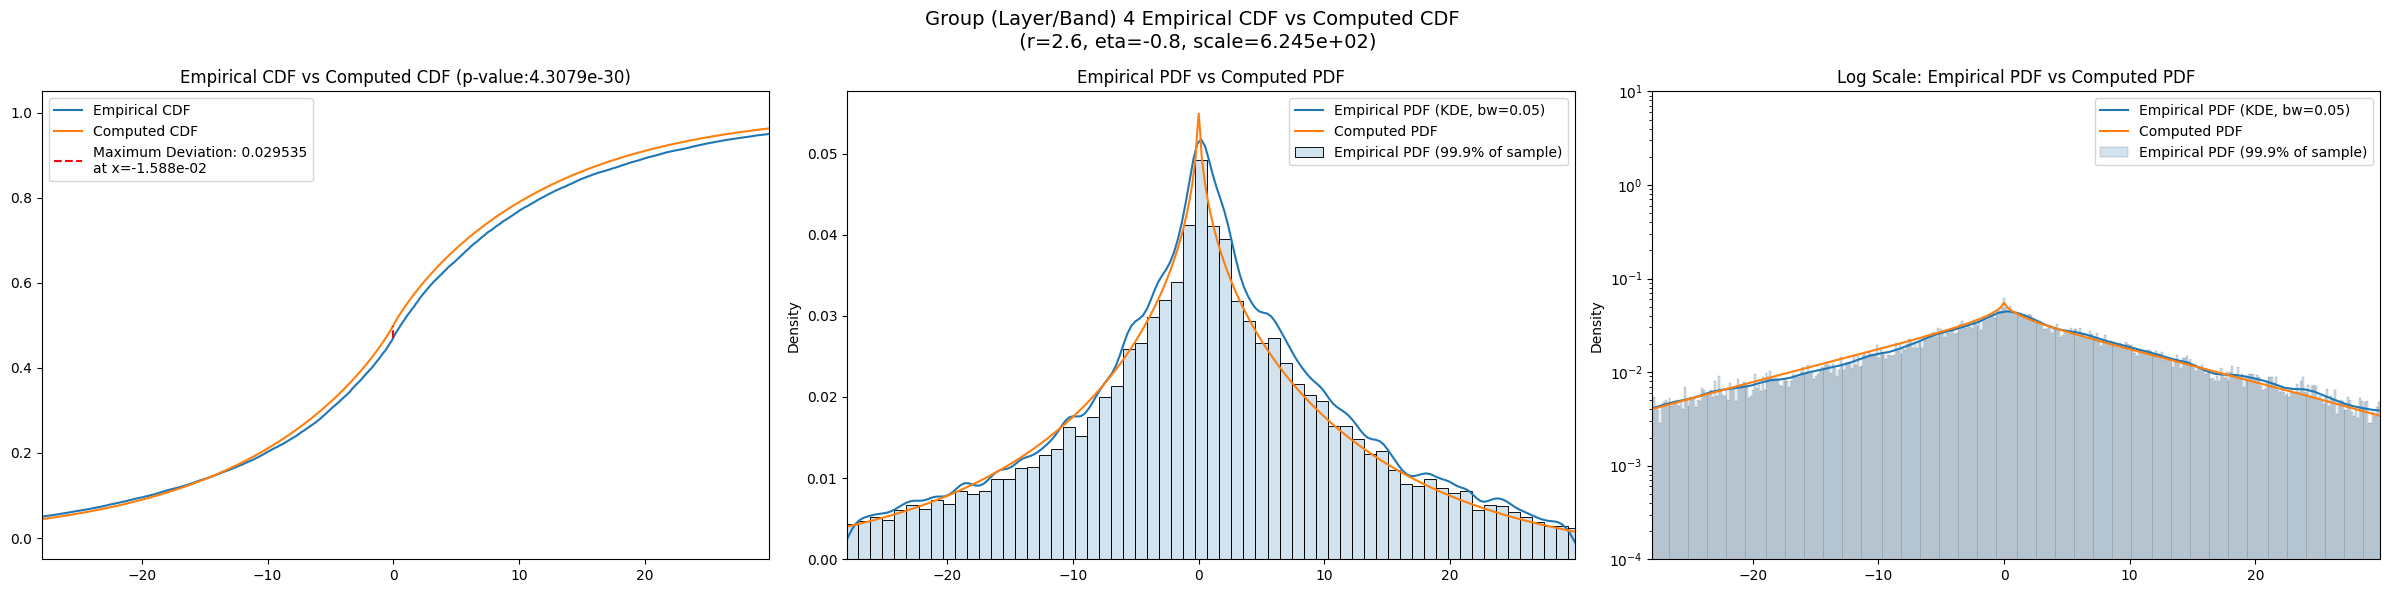

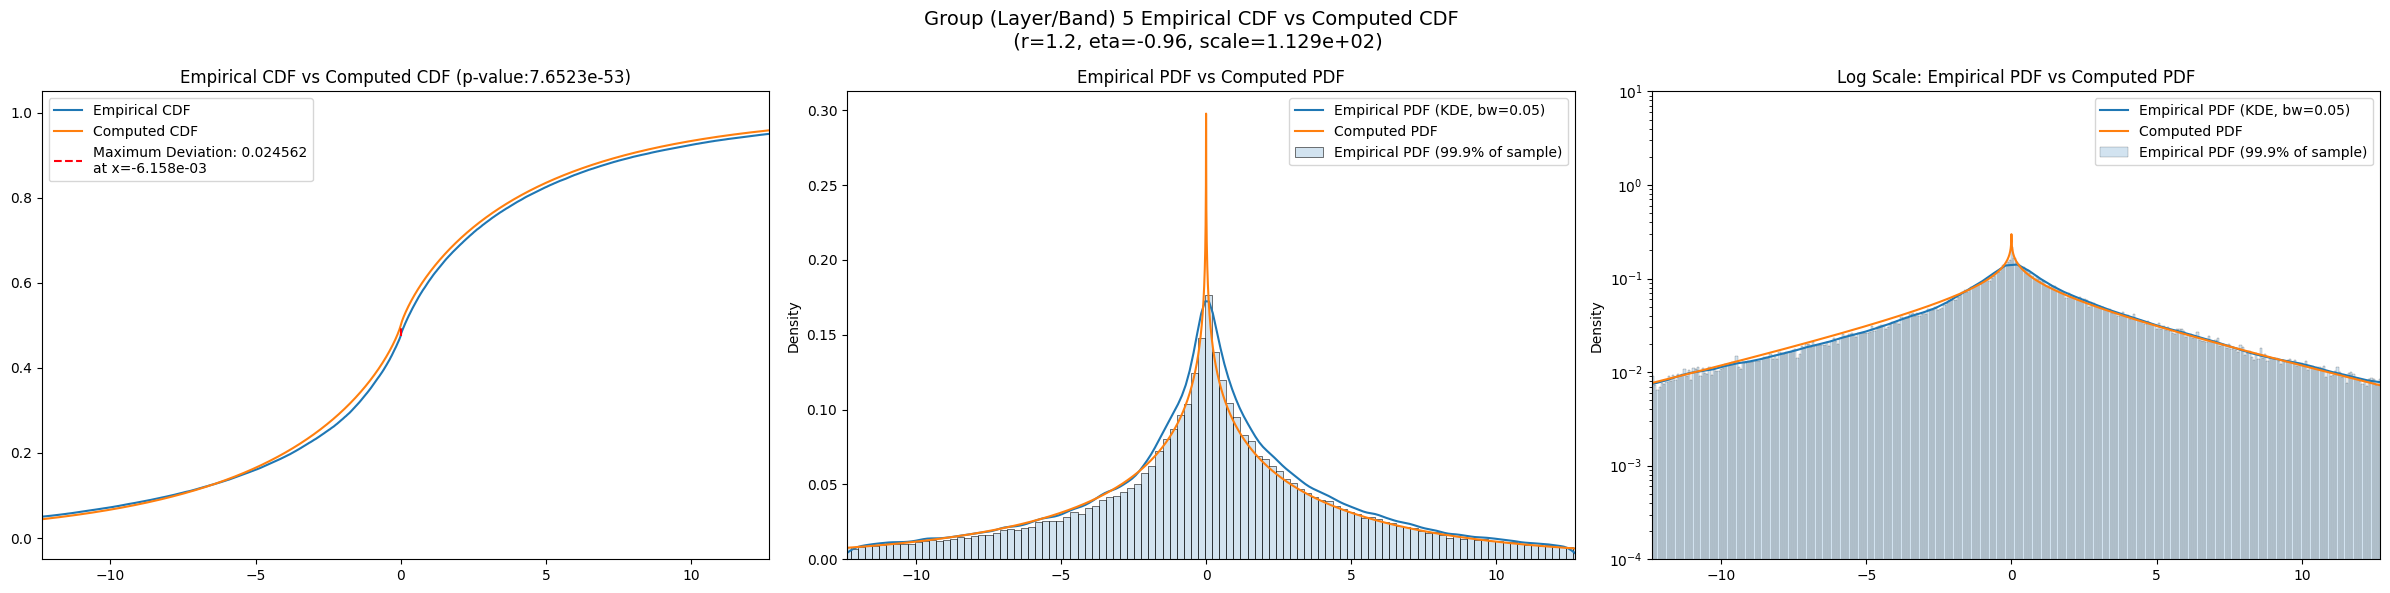

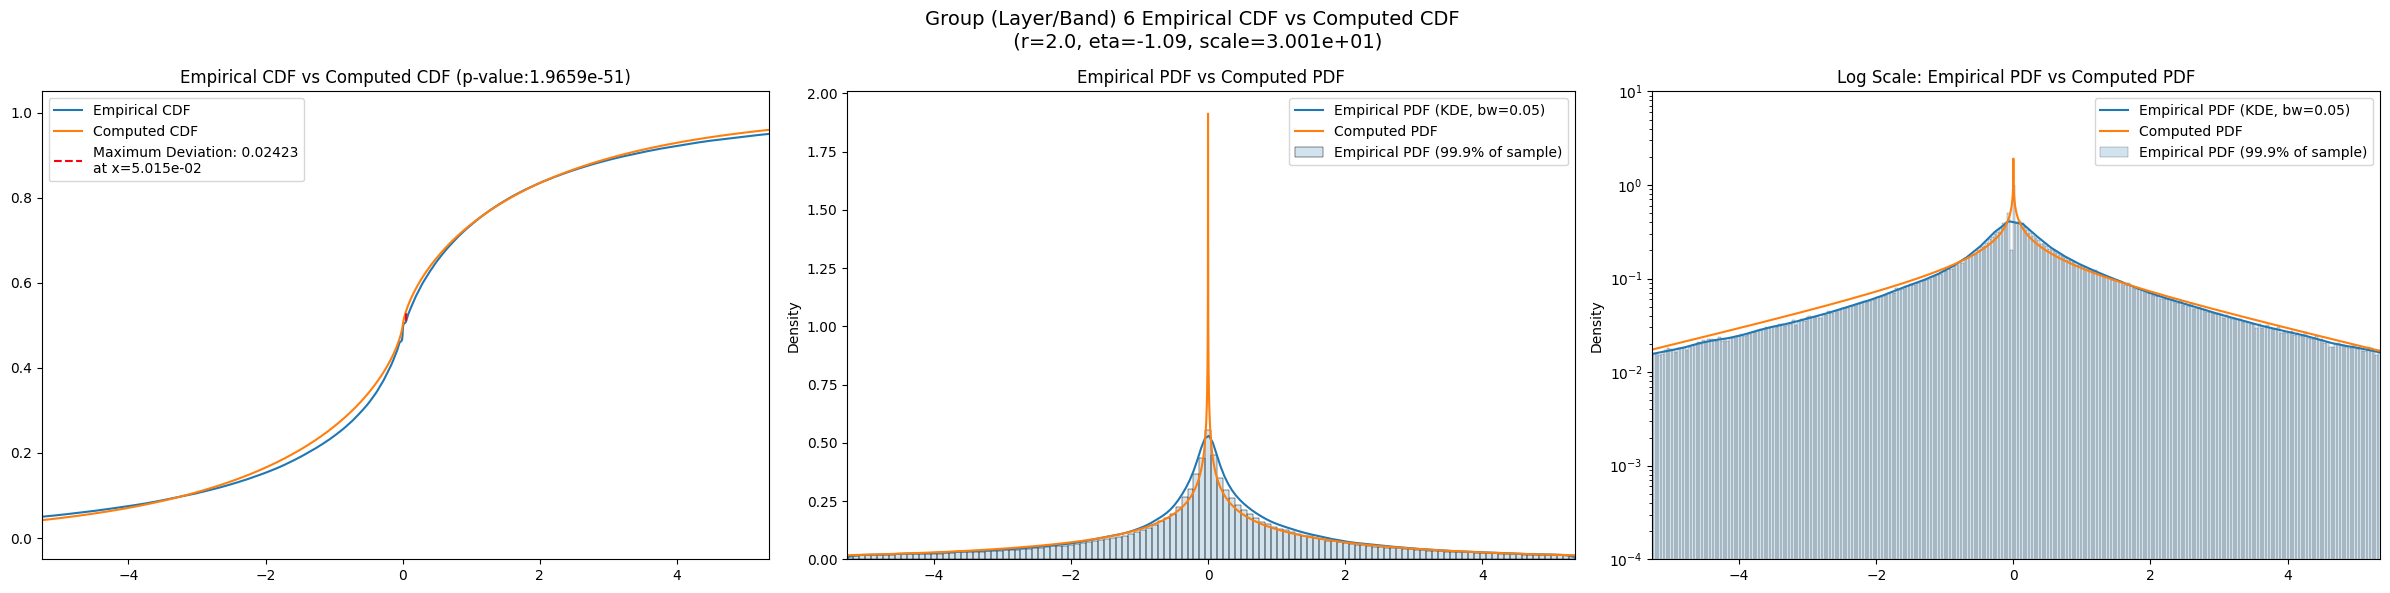

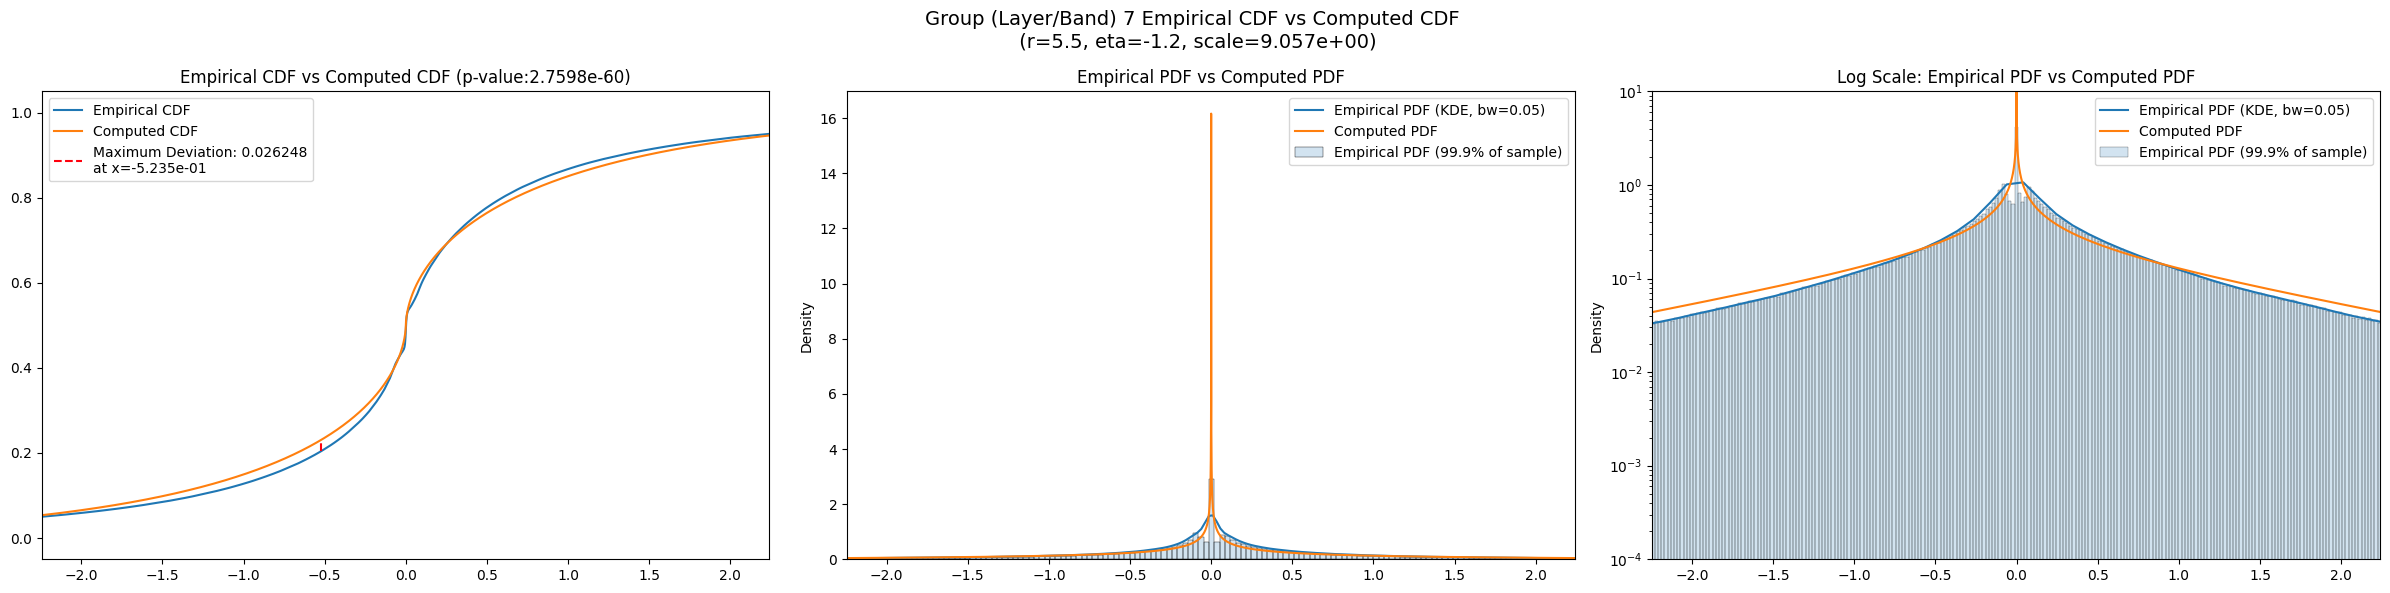

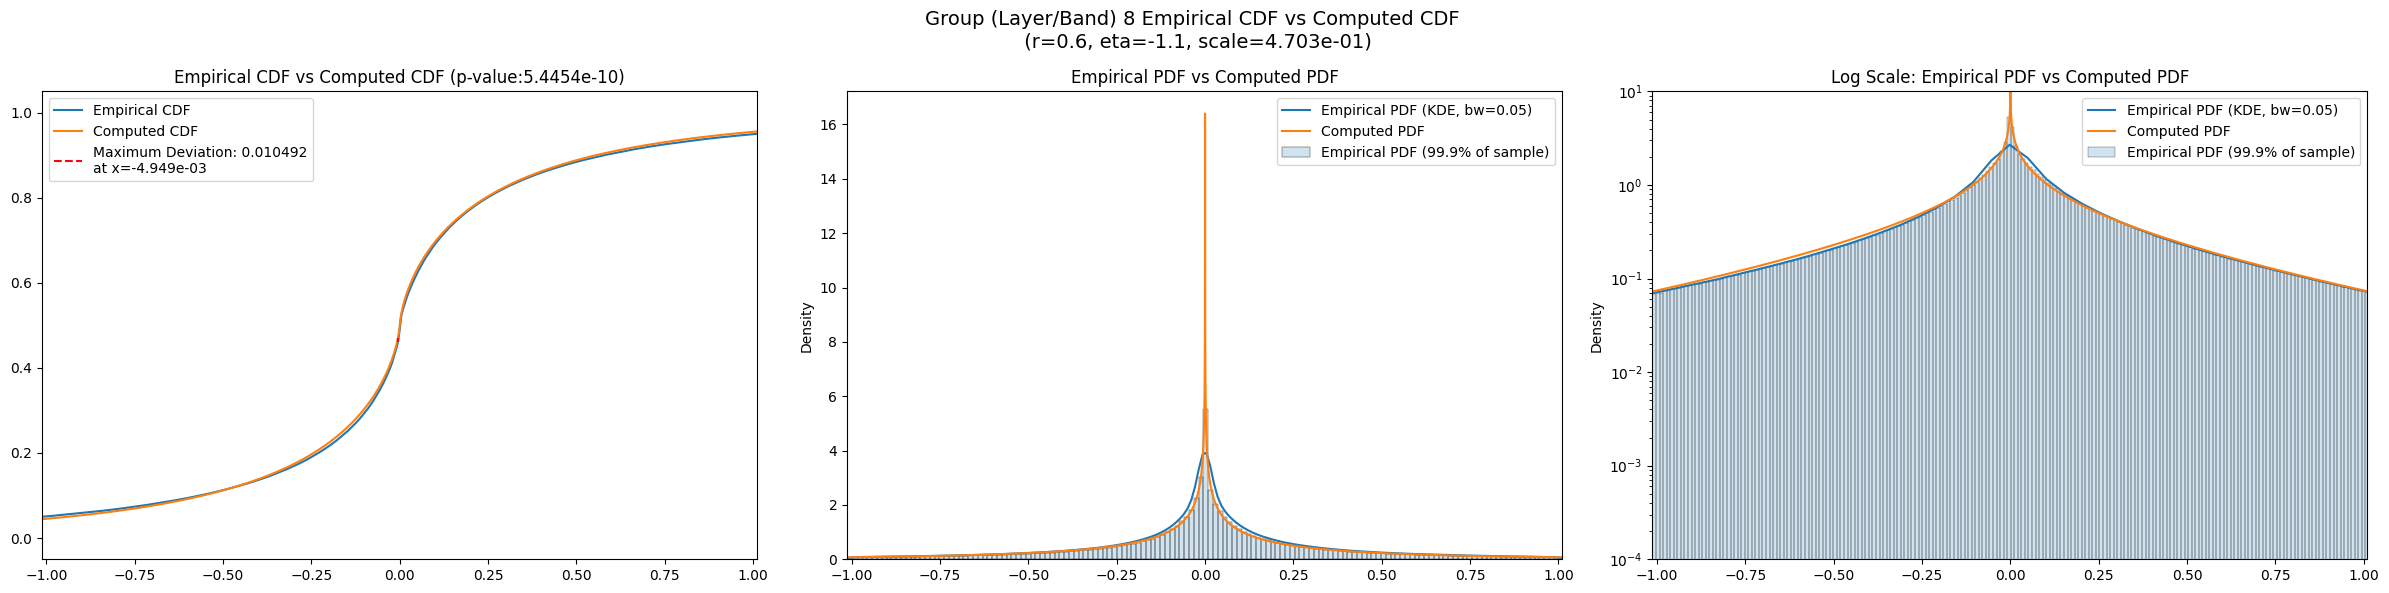

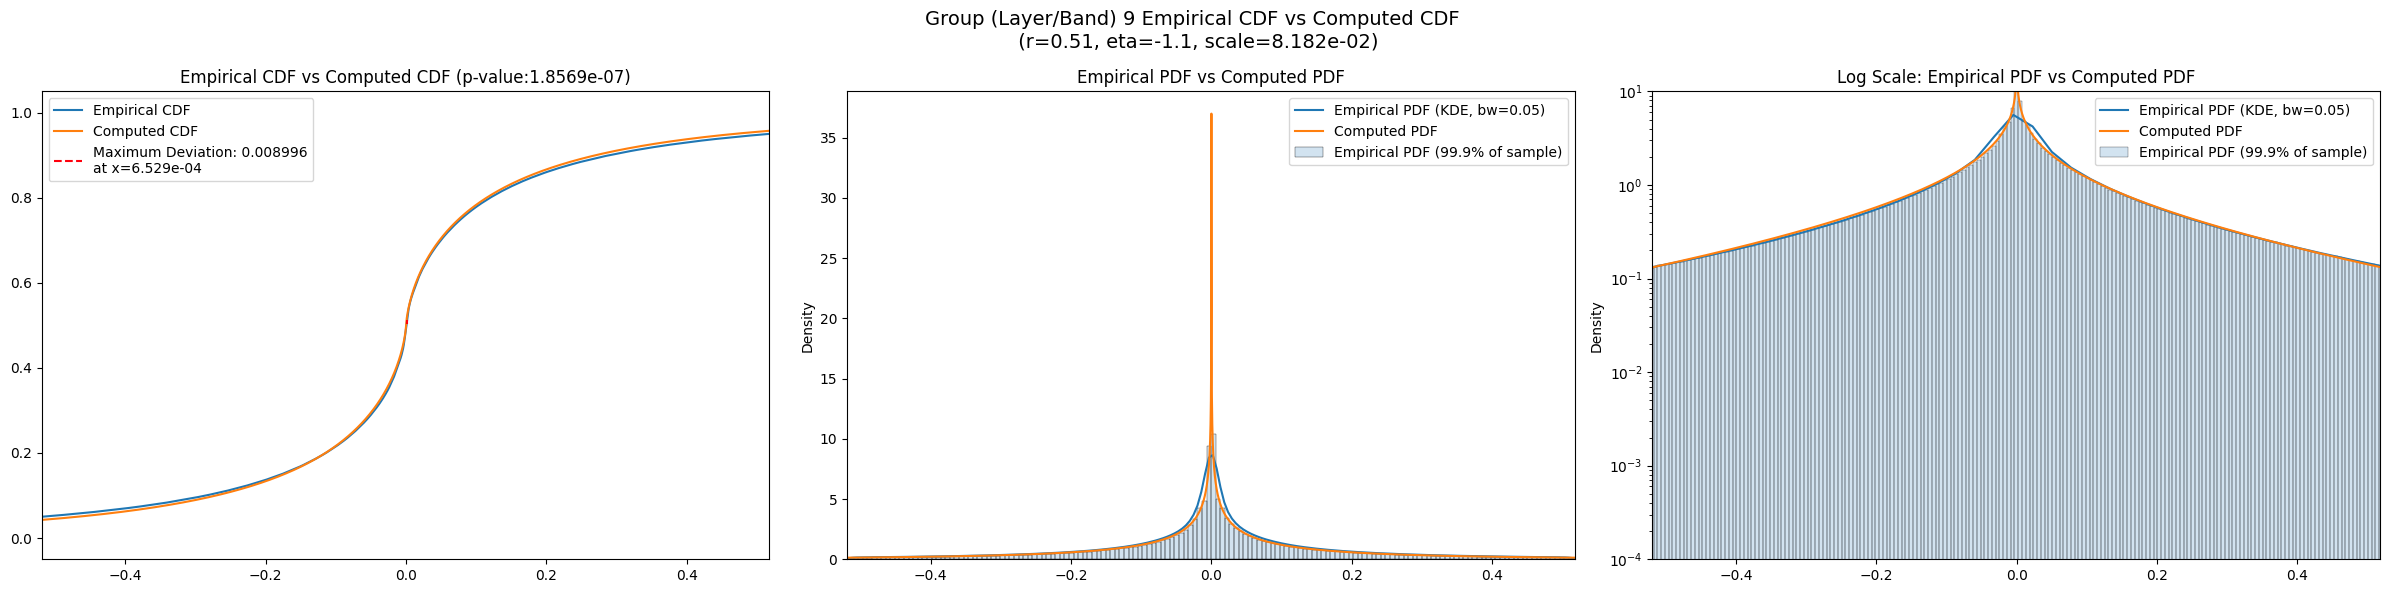

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7033.109400  6575.202000  7502.255000  -0.389985   -0.521723   
3      1485.386800  1423.772500  1548.948900   0.637286    0.503919   
4       299.227260   283.794860   315.127100   2.125775    1.787534   
5        58.351280    54.677464    62.158474   4.274248    3.563068   
6        11.546280    10.649501    12.528811   7.894427    5.764907   
7         2.319492     2.104414     2.579518  13.343580    8.176902   
8         0.523807     0.467204     0.608356  23.059578   10.370432   
9         0.142163     0.126417     0.166078  25.015984   11.196094   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.248600           2446             0.060606       20.0         20.0   
3        0.776592           9784             0.046237        8.9         -0.4   
4        2.500192          39136             0.029500        2.8         -0.8   
5        5.217214         156544             0.024735        0.8         -0.9   
6       14.354151         626176             0.025076        2.1         -1.1   
7       37.261646        2504704             0.026248        5.5         -1.2   
8       96.503456       10018816             0.010492        0.6         -1.1   
9       99.903610       40075264             0.009020        0.5         -1.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       84.808800              0.057728          1.583140e-07   
3      ...       31.858900              0.049949          1.183700e-21   
4      ...       12.817300              0.049947          2.743520e-85   
5      ...        4.697150              0.061876          0.000000e+00   
6      ...        1.746600              0.070928          0.000000e+00   
7      ...        0.679899              0.074623          0.000000e+00   
8      ...        0.292775              0.076595          0.000000e+00   
9      ...        0.141991              0.079869          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          84.132000             0.068544         1.948290e-10  70.053600   
3          35.006600             0.046695         5.611780e-19  26.007400   
4          10.986900             0.031124         2.273680e-33   9.286380   
5           4.023950             0.036444        4.401510e-181   3.304140   
6           1.501240             0.044838         0.000000e+00   1.205920   
7           0.582939             0.048994         0.000000e+00   0.462206   
8           0.250459             0.051397         0.000000e+00   0.196292   
9           0.120620             0.055579         0.000000e+00   0.094126   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.061817   1.439240e-08          2.978772e-08  
3           0.046381   9.940310e-19          1.293094e-18  
4           0.035596   1.608020e-43          5.081416e-30  
5           0.042085  2.316810e-241          7.739322e-83  
6           0.048522   0.000000e+00                   NaN  
7           0.051624   0.000000e+00          0.000000e+00  
8           0.053691   0.000000e+00          0.000000e+00  
9           0.057512   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.060606                 0.027391          0.060606   
3                 0.046237                 0.013713          0.046237   
4                 0.029500                 0.006861          0.029499   
5                 0.024735                 0.003431          0.024616   
6                 0.025076                 0.001716          0.024230   
7                 0.026248                 0.000858          0.026248   
8                 0.010492                 0.000429          0.010492   
9                 0.009020                 0.000215          0.008996   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.057728             0.068544       0.061817  
3                  0.049949             0.046695       0.046381  
4                  0.049947             0.031124       0.035596  
5                  0.061876             0.036444       0.042085  
6                  0.070928             0.044838       0.048522  
7                  0.074623             0.048994       0.051624  
8                  0.076595             0.051397       0.053691  
9                  0.079869             0.055579       0.057512

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             7033.109400          0.060606   20.00     20.00  7183.784645   
3             1485.386800          0.046237    8.90     -0.40  2938.163651   
4              256.596954          0.029499    2.60     -0.80   624.506493   
5               51.651825          0.024616    1.20     -0.96   112.934627   
6                8.656344          0.024230    2.00     -1.09    30.007037   
7                1.956683          0.026248    5.50     -1.20     9.057073   
8                0.413506          0.010492    0.60     -1.10     0.470282   
9                0.110863          0.008996    0.51     -1.10     0.081824   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                    225.0  
5                    275.0  
6                    600.0  
7                    200.0  
8                    250.0  
9                    250.0

In [21]:
eng.quit()